# Late Fusion
## Modality 2: Household food and health expenses

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

### Paths

In [2]:
input_path = '../../../2_data_preprocessing/output/'

output_path = '../output/'

# Global configuration path
glob_conf_path = '../../../config/global_config_paper.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Load and shuffle data

In [4]:
train_df = pd.read_csv(os.path.join(input_path, 'train_m2_norm_df.csv'))

In [5]:
train_df

,exp_fruits,exp_vegetables,exp_corn,exp_bread,exp_grains,exp_oil_sugar,exp_meat,exp_dairy,exp_eggs,exp_snacks,...,exp_bottled_water,exp_soda,exp_alcohol,exp_tobacco,exp_not_homemade,monthly_income,total_food_exp,total_medical_exp,label,group
0,0.088605,0.136628,0.108527,0.031008,0.089922,0.038760,0.155039,0.131078,0.054264,0.090439,...,0.077519,0.000000,0.209302,0.000000,0.000000,0.004473,0.121519,0.000000,0.0,5
1,0.000000,0.000000,0.028194,0.070485,0.204405,0.132159,0.000000,0.248298,0.055507,0.000000,...,0.042291,0.123505,0.000000,0.000000,0.264317,0.000792,0.106734,0.038773,0.0,4
2,0.134155,0.137911,0.046948,0.062598,0.054460,0.032864,0.234742,0.099232,0.065728,0.000000,...,0.098592,0.065812,0.000000,0.000000,0.000000,0.004971,0.201641,0.013761,1.0,2
3,0.086591,0.089015,0.056818,0.101010,0.087879,0.037879,0.151515,0.106749,0.053030,0.000000,...,0.090909,0.095576,0.000000,0.042487,0.000000,0.000991,0.124380,0.000000,1.0,1
4,0.086591,0.089015,0.056818,0.101010,0.087879,0.037879,0.151515,0.106749,0.053030,0.000000,...,0.090909,0.095576,0.000000,0.042487,0.000000,0.000991,0.124380,0.000000,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7814,0.215660,0.088679,0.084906,0.075472,0.065660,0.066038,0.188679,0.132933,0.092453,0.000000,...,0.028302,0.132244,0.000000,0.000000,0.000000,0.002085,0.099580,0.000000,1.0,5
7815,0.000000,0.000000,0.344037,0.305810,0.000000,0.000000,0.000000,0.387823,0.160550,0.000000,...,0.036697,0.000000,0.000000,0.000000,0.000000,0.000991,0.040061,0.000000,0.0,5
7816,0.000000,0.451923,0.192308,0.085470,0.089231,0.038462,0.000000,0.126457,0.071795,0.149573,...,0.038462,0.000000,0.000000,0.000000,0.000000,0.001787,0.072873,0.000000,0.0,4
7817,0.000000,0.451923,0.192308,0.085470,0.089231,0.038462,0.000000,0.126457,0.071795,0.149573,...,0.038462,0.000000,0.000000,0.000000,0.000000,0.001787,0.072873,0.000000,0.0,1


In [6]:
from sklearn.utils import shuffle

train_shuffled_df = shuffle(train_df, random_state=seed).reset_index(drop=True)

In [7]:
train_shuffled_df

,exp_fruits,exp_vegetables,exp_corn,exp_bread,exp_grains,exp_oil_sugar,exp_meat,exp_dairy,exp_eggs,exp_snacks,...,exp_bottled_water,exp_soda,exp_alcohol,exp_tobacco,exp_not_homemade,monthly_income,total_food_exp,total_medical_exp,label,group
0,0.062187,0.063928,0.099021,0.072543,0.037867,0.039173,0.163221,0.107330,0.048749,0.126950,...,0.000000,0.274561,0.000000,0.104617,0.000000,0.002682,0.086131,0.000459,0.0,1
1,0.000000,0.325936,0.194175,0.055479,0.096533,0.097087,0.083218,0.058631,0.038835,0.000000,...,0.049931,0.145817,0.000000,0.000000,0.000000,0.000891,0.067245,0.000000,0.0,4
2,0.156361,0.321477,0.287278,0.098495,0.047606,0.068399,0.068399,0.021204,0.019152,0.000000,...,0.021888,0.000000,0.000000,0.000000,0.000000,0.005070,0.068199,0.000000,0.0,5
3,0.197069,0.101293,0.129310,0.091954,0.100000,0.086207,0.172414,0.121473,0.060345,0.100575,...,0.025862,0.000000,0.000000,0.000000,0.000000,0.001488,0.109119,0.000000,0.0,3
4,0.236483,0.121552,0.068966,0.027586,0.040000,0.027586,0.275862,0.058307,0.048276,0.000000,...,0.020690,0.038670,0.000000,0.000000,0.000000,0.002483,0.136780,0.000000,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7814,0.352778,0.181327,0.231481,0.000000,0.071605,0.089506,0.077160,0.000000,0.064815,0.000000,...,0.030864,0.000000,0.000000,0.000000,0.000000,0.001986,0.060282,0.000000,0.0,4
7815,0.483639,0.165726,0.084626,0.000000,0.163611,0.077574,0.000000,0.087447,0.000000,0.000000,...,0.070522,0.000000,0.000000,0.000000,0.000000,0.001836,0.066101,0.000000,0.0,4
7816,0.229980,0.118209,0.015091,0.067069,0.000000,0.000000,0.251509,0.141760,0.105634,0.000000,...,0.054326,0.000000,0.000000,0.000000,0.150905,0.004473,0.188096,0.071101,1.0,3
7817,0.000000,0.152202,0.077720,0.062176,0.120207,0.041451,0.077720,0.160622,0.054404,0.108808,...,0.000000,0.000000,0.000000,0.000000,0.323834,0.000742,0.035292,0.006881,0.0,1


## Other functions

In [8]:
from sklearn.metrics import confusion_matrix
    
def plot_save_conf_matrix(X, y, cv, clf, title, file_name, report=False):
    
    # Initialize some variables to store results
    conf_mat_avg = np.zeros([2,2])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)    
        y_pred = clf.predict(X_val)                       # Predict class
        conf_mat_tmp = confusion_matrix(y_val,            # Compute confusion matrix for this batch
                                        y_pred,
                                        normalize='true'
                                       )
        conf_mat_avg += conf_mat_tmp
    
    conf_mat_avg /= n_groups
    
    
    df_cm = pd.DataFrame(conf_mat_avg, list(label_id_to_label_num.keys()), list(label_id_to_label_num.keys()))
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    plt.figure(figsize=(5,5))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')

## Elastic Net SGD Classifier

In [9]:
from sklearn.linear_model import SGDClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
n_iter_no_change_values = [20, 50, 100, 150]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
parameters              = {'penalty': ['elasticnet'],
                           'class_weight': ['balanced'],
                           'loss': ['log'],
                           'random_state': [seed],
                           'alpha': alpha_values,
                           'l1_ratio': l1_ratio_values,
                           'n_iter_no_change': n_iter_no_change_values,
                           'max_iter': [2500]
                          }

elasticnet = SGDClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = elasticnet, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_groups)+'_logocv_m2.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_m2.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_m2.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
SGDClassifier(alpha=0.00075, class_weight='balanced', l1_ratio=0.3, loss='log',
              max_iter=2500, n_iter_no_change=50, penalty='elasticnet',
              random_state=27)


In [10]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_l1_ratio,param_loss,param_max_iter,param_n_iter_no_change,...,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
261,0.510799,0.194298,0.004400,0.000490,0.00075,balanced,0.3,log,2500,50,...,27,"{'alpha': 0.00075, 'class_weight': 'balanced',...",0.561757,0.547770,0.538419,0.528838,0.542590,0.543875,0.010885,1
197,0.268801,0.163771,0.004000,0.000001,0.0005,balanced,0.5,log,2500,50,...,27,"{'alpha': 0.0005, 'class_weight': 'balanced', ...",0.560283,0.548637,0.538797,0.528484,0.542843,0.543809,0.010542,2
267,0.867399,0.416275,0.028799,0.049599,0.00075,balanced,0.35,log,2500,150,...,27,"{'alpha': 0.00075, 'class_weight': 'balanced',...",0.561585,0.547756,0.538163,0.528541,0.542988,0.543806,0.010929,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.550773462387124
AUC_std (train): 0.0021553789569948812
AUC_avg (validation): 0.5438747858473344
AUC_std (validation): 0.010885283291416366


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


UAR_avg (train): 0.5335762111298824
UAR_std (train): 0.001984734511678581
UAR_avg (validation): 0.5335251278445852
UAR_std (validation): 0.009362629901190574


c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


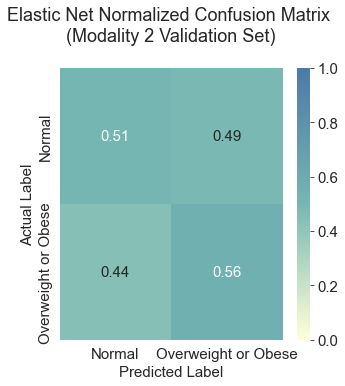

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_m2.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Elastic Net Normalized Confusion Matrix 
(Modality 2 Validation Set)
""",
                      file_name = 'conf_mat_elastic_net_m2.svg',
                      report    = True 
                     )

## kNN Classifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_neigh_values   = np.arange(1, 905, 5).tolist()
leaf_size_values = [10, 20, 30]
algorithm_values = ['ball_tree','brute', 'kd_tree']
parameters      = {'n_neighbors': n_neigh_values,
                   'leaf_size': leaf_size_values,
                   'weights': ['uniform'],
                   'algorithm': algorithm_values,
                   'metric': ['manhattan'],
                   'n_jobs': [-1]
                  }

knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = knn, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_groups)+'_logocv_m2.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_knn_m2.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_m2.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 1629 candidates, totalling 8145 fits
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='manhattan',
                     n_jobs=-1, n_neighbors=896)


In [13]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
179,0.101199,0.031633,2.591400,0.128776,ball_tree,10,manhattan,-1,896,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'm...",0.543973,0.556167,0.536706,0.520058,0.531618,0.537704,0.012080,1
1265,0.166600,0.076480,3.227400,0.405730,kd_tree,10,manhattan,-1,896,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 10, 'met...",0.544000,0.556005,0.536840,0.520031,0.531622,0.537700,0.012039,2
541,0.077999,0.031476,1.949201,0.204140,ball_tree,30,manhattan,-1,896,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",0.544065,0.555927,0.536763,0.519939,0.531486,0.537636,0.012064,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s finished


AUC_avg (train): 0.5463578950962942
AUC_std (train): 0.0022565783260283913
AUC_avg (validation): 0.5377043366424246
AUC_std (validation): 0.012079597874737303


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.1s finished


UAR_avg (train): 0.5005219782486878
UAR_std (train): 0.0003344910517573516
UAR_avg (validation): 0.5003188278507297
UAR_std (validation): 0.00039084647037529804


c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature name

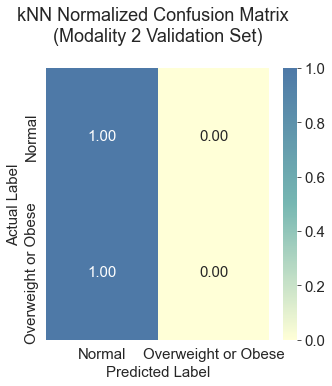

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_m2.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """kNN Normalized Confusion Matrix  
(Modality 2 Validation Set)
""",
                      file_name = 'conf_mat_knn_m2.svg'
                     )

## Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters      = {'criterion': criterion_values,
                   'splitter': splitter_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'max_features': max_features_values,
                   'class_weight': ['balanced'],
                   'random_state': [seed]
                  }

dt = DecisionTreeClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = dt, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         random_state        = seed,
                         n_iter              = 5000,
                         n_jobs              = -1
                         )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_tree_'+str(n_groups)+'_logocv_m2.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_tree_m2.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_tree_m2.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
DecisionTreeClassifier(class_weight='balanced', max_depth=30, max_features=12,
                       min_samples_leaf=0.1, min_samples_split=0.2,
                       random_state=27, splitter='random')


In [16]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,...,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
567,0.024598,0.030198,0.004399,0.000800,random,27,0.2,0.1,12,30,...,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.505862,0.554451,0.529509,0.537781,0.523207,0.530162,0.016045,1
2359,0.024599,0.024516,0.011400,0.008064,random,27,0.1,0.1,12,10,...,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.505862,0.554451,0.529509,0.537781,0.523207,0.530162,0.016045,1
4078,0.017000,0.011117,0.007401,0.004841,random,27,0.2,0.1,12,50,...,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.505862,0.554451,0.529509,0.537781,0.523207,0.530162,0.016045,1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


AUC_avg (train): 0.5321093666649632
AUC_std (train): 0.004008185838060434
AUC_avg (validation): 0.5301619767788475
AUC_std (validation): 0.01604531221894215


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


UAR_avg (train): 0.5238023146349352
UAR_std (train): 0.0027577045850821448
UAR_avg (validation): 0.5166631727560347
UAR_std (validation): 0.013748737808126235


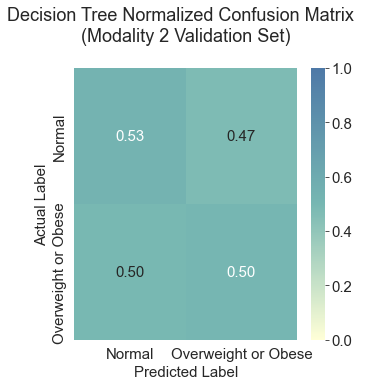

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_tree_m2.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Decision Tree Normalized Confusion Matrix  
(Modality 2 Validation Set)
""",
                      file_name = 'conf_mat_tree_m2.svg'
                     )

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'random_state': [seed],
                   'class_weight': class_weight_values,
                   'n_jobs': [-1]
                  }

rf = RandomForestClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = rf, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         n_iter              = 5000,
                         random_state        = seed,
                         n_jobs              = -1
                        )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_groups)+'_logocv_m2.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_rf_m2.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_m2.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
RandomForestClassifier(class_weight='balanced', max_depth=30,
                       max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=242, n_jobs=-1,
                       random_state=27)


In [19]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_jobs,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,...,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3022,8.044100,0.162692,2.429000,0.236967,27,-1,242,10,4,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.558412,0.559435,0.564956,0.564303,0.554478,0.560317,0.003896,1
1461,7.298519,1.849877,3.335622,0.915951,27,-1,247,10,4,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.558676,0.559343,0.564867,0.562841,0.554454,0.560036,0.003597,2
1664,7.391001,1.733969,2.368625,2.050521,27,-1,262,10,4,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.556289,0.558997,0.565736,0.563695,0.555116,0.559967,0.004127,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.990441431677267
AUC_std (train): 0.0005261885114865425
AUC_avg (validation): 0.5603165791118511
AUC_std (validation): 0.003896482231068088


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


UAR_avg (train): 0.9360964666336663
UAR_std (train): 0.0022144232283724643
UAR_avg (validation): 0.5406016878759021
UAR_std (validation): 0.013540974438711524


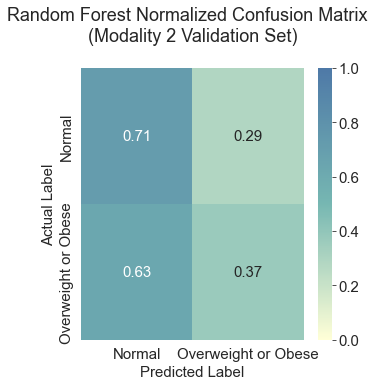

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label 
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_m2.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Random Forest Normalized Confusion Matrix  
(Modality 2 Validation Set)
""",
                      file_name = 'conf_mat_rf_m2.svg'
                     )